In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Defining transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizing between -1 and 1
])

# Loading datasets
train_dataset = datasets.FashionMNIST(root='./datasets/', train=True, transform=transform, download=True)

# Creating data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

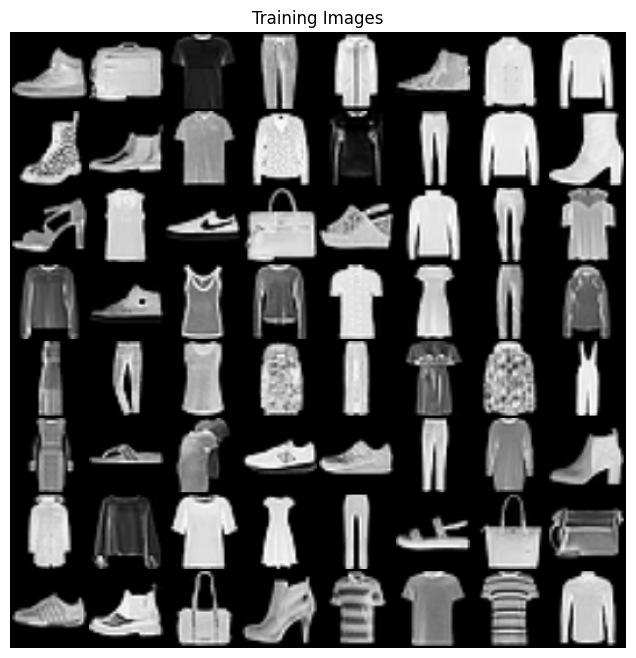

In [7]:
# Visualizing sample training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

In [8]:
# Defining common components for generator and discriminator
nz = 128  # Size of the latent vector (noise)
nc = 1    # Number of channels in the training images (grayscale)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
num_classes = 10  # Number of classes in Fashion MNIST
image_size = 64

In [9]:
# Defining the generator network
class Generator(nn.Module):
    def __init__(self, architecture='A'):
        super(Generator, self).__init__()
        self.architecture = architecture
        self.label_emb = nn.Embedding(num_classes, num_classes)
        input_dim = nz + num_classes  # Combining noise and label embedding

        if architecture == 'A':
            self.main = nn.Sequential(
                nn.ConvTranspose2d(input_dim, ngf * 8, 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),

                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),

                nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),

                nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
                nn.Tanh()
            )
        elif architecture == 'B':
            self.main = nn.Sequential(
                nn.ConvTranspose2d(input_dim, ngf * 16, 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * 16),
                nn.ReLU(True),

                nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),

                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),

                nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),

                nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
                nn.Tanh()
            )

    def forward(self, noise, labels):
        # Combining label embedding and noise to produce input
        label_embed = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((noise, label_embed), 1)
        return self.main(input)

In [55]:
# Defining the discriminator network
class Discriminator(nn.Module):
    def __init__(self, architecture='A'):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        input_dim = nc + num_classes  # Concatenate image and label embedding

        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_dim, ndf * 2, 4, 2, 1, bias=False),  # Output: ndf*2 x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),     # Output: ndf*4 x 16 x 16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),     # Output: ndf*8 x 8 x 8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),    # Output: ndf*16 x 4 x 4
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Placeholder for the linear layer, to be dynamically initialized
        self.fc = None

    def forward(self, img, labels):
        # Ensure labels are on the same device as images
        labels = labels.to(img.device)

        # Embed the labels and reshape them to match the input size
        label_embed = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_embed = label_embed.expand(-1, -1, img.size(2), img.size(3))

        # Concatenate the image and label embeddings along the channel dimension
        input = torch.cat((img, label_embed), dim=1)

        # Pass through the convolutional layers
        features = self.conv_layers(input)

        # Debug: Print feature shape to ensure correctness
        #print(f"Feature shape after conv layers: {features.shape}")

        # Flatten the features
        flattened_features = features.view(features.size(0), -1)
        flattened_size = flattened_features.size(1)  # Get the size dynamically

        # Initialize the linear layer if not already done
        if self.fc is None or self.fc.in_features != flattened_size:
            #print(f"Initializing Linear layer with input size: {flattened_size}")
            self.fc = nn.Linear(flattened_size, 1).to(img.device)  # Create linear layer

        # Pass through the linear layer
        output = self.fc(flattened_features)

        # Ensure output shape matches [batch_size]
        return output.view(-1)

In [38]:
# Utility for each GAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [39]:
# Gradient Penalty for WGAN-GP
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [40]:
# Common training parameters for each GAN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
num_epochs = 20
lambda_gp = 10  # Gradient penalty coefficient for WGAN-GP
critic_iters = 5  # Number of critic iterations per generator iteration for WGANs

Device:  cuda


In [41]:
# Training function for all GAN
def train_gan(gan_type='DCGAN', architecture='A'):
    # Initialize generator and discriminator
    netG = Generator(architecture).to(device)
    netD = Discriminator(architecture).to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)

    # Optimizers
    optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss

    real_label = 1.0  # Floating-point label for real
    fake_label = 0.0  # Floating-point label for fake

    G_losses = []
    D_losses = []

    print(f"Starting Training Loop for {gan_type} with architecture {architecture}...")
    for epoch in range(num_epochs):
        for i, (real_images, labels) in enumerate(tqdm(train_loader)):
            real_images = real_images.to(device)
            labels = labels.to(device)
            batch_size = real_images.size(0)

            # --------------------
            # Train Discriminator
            # --------------------
            netD.zero_grad()

            # Train with real images
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)  # Ensure float type
            output = netD(real_images, labels).view(-1)  # Get discriminator output
            errD_real = criterion(output, label)  # Calculate loss
            errD_real.backward()

            # Train with fake images
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise, labels)
            label.fill_(fake_label)  # Update label for fake images
            output = netD(fake_images.detach(), labels).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            optimizerD.step()

            errD = errD_real + errD_fake  # Total discriminator loss

            # --------------------
            # Train Generator
            # --------------------
            netG.zero_grad()
            label.fill_(real_label)  # Fake labels are real for generator loss
            output = netD(fake_images, labels).view(-1)
            errG = criterion(output, label)  # Calculate generator loss
            errG.backward()
            optimizerG.step()

            # Save losses for plotting
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] \t Loss_D: {errD.item():.4f} \t Loss_G: {errG.item():.4f}")

    return G_losses, D_losses, netG


In [56]:
architectures = ['A', 'B']
gan_types = ['DCGAN', 'WGAN', 'WGAN-GP']
results = {}

# Training DCGAN, WGAN, and WGAN-GP for both architectures
for arch in architectures:
    results[arch] = {}
    for gan_type in gan_types:
        G_losses, D_losses, netG = train_gan(gan_type=gan_type, architecture=arch)
        results[arch][gan_type] = {
            'G_losses': G_losses,
            'D_losses': D_losses,
            'netG': netG
        }

Starting Training Loop for DCGAN with architecture A...


100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


Epoch [1/20] 	 Loss_D: 1.4139 	 Loss_G: 0.8659


100%|██████████| 938/938 [00:46<00:00, 20.34it/s]


Epoch [2/20] 	 Loss_D: 1.5082 	 Loss_G: 0.6887


100%|██████████| 938/938 [00:46<00:00, 20.18it/s]


Epoch [3/20] 	 Loss_D: 1.4056 	 Loss_G: 0.6885


100%|██████████| 938/938 [00:47<00:00, 19.83it/s]


Epoch [4/20] 	 Loss_D: 1.4024 	 Loss_G: 0.6276


100%|██████████| 938/938 [00:46<00:00, 20.09it/s]


Epoch [5/20] 	 Loss_D: 1.4838 	 Loss_G: 0.7413


100%|██████████| 938/938 [00:46<00:00, 20.05it/s]


Epoch [6/20] 	 Loss_D: 1.4156 	 Loss_G: 0.7518


100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


Epoch [7/20] 	 Loss_D: 1.3061 	 Loss_G: 0.7620


100%|██████████| 938/938 [00:46<00:00, 20.00it/s]


Epoch [8/20] 	 Loss_D: 1.2614 	 Loss_G: 0.7418


100%|██████████| 938/938 [00:46<00:00, 20.04it/s]


Epoch [9/20] 	 Loss_D: 1.4222 	 Loss_G: 0.7977


100%|██████████| 938/938 [00:47<00:00, 19.77it/s]


Epoch [10/20] 	 Loss_D: 1.4040 	 Loss_G: 0.7273


100%|██████████| 938/938 [00:47<00:00, 19.78it/s]


Epoch [11/20] 	 Loss_D: 1.1551 	 Loss_G: 0.8410


100%|██████████| 938/938 [00:47<00:00, 19.95it/s]


Epoch [12/20] 	 Loss_D: 1.3753 	 Loss_G: 0.7030


100%|██████████| 938/938 [00:46<00:00, 20.15it/s]


Epoch [13/20] 	 Loss_D: 1.3910 	 Loss_G: 0.7066


100%|██████████| 938/938 [00:46<00:00, 20.10it/s]


Epoch [14/20] 	 Loss_D: 1.5030 	 Loss_G: 0.6899


100%|██████████| 938/938 [00:46<00:00, 20.13it/s]


Epoch [15/20] 	 Loss_D: 1.2391 	 Loss_G: 0.8120


100%|██████████| 938/938 [00:46<00:00, 20.05it/s]


Epoch [16/20] 	 Loss_D: 1.3939 	 Loss_G: 0.6873


100%|██████████| 938/938 [00:47<00:00, 19.73it/s]


Epoch [17/20] 	 Loss_D: 1.2548 	 Loss_G: 0.7850


100%|██████████| 938/938 [00:46<00:00, 20.05it/s]


Epoch [18/20] 	 Loss_D: 1.4600 	 Loss_G: 0.6814


100%|██████████| 938/938 [00:46<00:00, 20.15it/s]


Epoch [19/20] 	 Loss_D: 1.3409 	 Loss_G: 0.9438


100%|██████████| 938/938 [00:46<00:00, 20.15it/s]


Epoch [20/20] 	 Loss_D: 1.3308 	 Loss_G: 0.8121
Starting Training Loop for WGAN with architecture A...


100%|██████████| 938/938 [00:46<00:00, 20.01it/s]


Epoch [1/20] 	 Loss_D: 1.2585 	 Loss_G: 1.0408


100%|██████████| 938/938 [00:46<00:00, 20.07it/s]


Epoch [2/20] 	 Loss_D: 1.5433 	 Loss_G: 0.7170


100%|██████████| 938/938 [00:47<00:00, 19.64it/s]


Epoch [3/20] 	 Loss_D: 1.2007 	 Loss_G: 0.7572


100%|██████████| 938/938 [00:46<00:00, 20.01it/s]


Epoch [4/20] 	 Loss_D: 1.5612 	 Loss_G: 0.7386


100%|██████████| 938/938 [00:46<00:00, 20.12it/s]


Epoch [5/20] 	 Loss_D: 1.3289 	 Loss_G: 0.8166


100%|██████████| 938/938 [00:46<00:00, 20.18it/s]


Epoch [6/20] 	 Loss_D: 1.3654 	 Loss_G: 0.7202


100%|██████████| 938/938 [00:46<00:00, 20.10it/s]


Epoch [7/20] 	 Loss_D: 1.5018 	 Loss_G: 0.6922


100%|██████████| 938/938 [00:47<00:00, 19.91it/s]


Epoch [8/20] 	 Loss_D: 1.4529 	 Loss_G: 0.6905


100%|██████████| 938/938 [00:47<00:00, 19.93it/s]


Epoch [9/20] 	 Loss_D: 1.2837 	 Loss_G: 0.7653


100%|██████████| 938/938 [00:47<00:00, 19.62it/s]


Epoch [10/20] 	 Loss_D: 1.3746 	 Loss_G: 0.7789


100%|██████████| 938/938 [00:46<00:00, 20.12it/s]


Epoch [11/20] 	 Loss_D: 1.4571 	 Loss_G: 0.6847


100%|██████████| 938/938 [00:46<00:00, 20.19it/s]


Epoch [12/20] 	 Loss_D: 1.3608 	 Loss_G: 0.6704


100%|██████████| 938/938 [00:46<00:00, 20.09it/s]


Epoch [13/20] 	 Loss_D: 1.4191 	 Loss_G: 0.6914


100%|██████████| 938/938 [00:47<00:00, 19.95it/s]


Epoch [14/20] 	 Loss_D: 1.4206 	 Loss_G: 0.6447


100%|██████████| 938/938 [00:47<00:00, 19.88it/s]


Epoch [15/20] 	 Loss_D: 1.3485 	 Loss_G: 0.7640


100%|██████████| 938/938 [00:47<00:00, 19.73it/s]


Epoch [16/20] 	 Loss_D: 1.3615 	 Loss_G: 0.7244


100%|██████████| 938/938 [00:46<00:00, 19.97it/s]


Epoch [17/20] 	 Loss_D: 1.4091 	 Loss_G: 0.6759


100%|██████████| 938/938 [00:46<00:00, 20.01it/s]


Epoch [18/20] 	 Loss_D: 1.5165 	 Loss_G: 0.7058


100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


Epoch [19/20] 	 Loss_D: 1.4133 	 Loss_G: 0.7999


100%|██████████| 938/938 [00:46<00:00, 20.08it/s]


Epoch [20/20] 	 Loss_D: 1.5438 	 Loss_G: 0.7069
Starting Training Loop for WGAN-GP with architecture A...


100%|██████████| 938/938 [00:46<00:00, 20.01it/s]


Epoch [1/20] 	 Loss_D: 1.6835 	 Loss_G: 0.6230


100%|██████████| 938/938 [00:47<00:00, 19.88it/s]


Epoch [2/20] 	 Loss_D: 1.3962 	 Loss_G: 0.7543


100%|██████████| 938/938 [00:46<00:00, 19.96it/s]


Epoch [3/20] 	 Loss_D: 1.3672 	 Loss_G: 0.6959


100%|██████████| 938/938 [00:46<00:00, 20.18it/s]


Epoch [4/20] 	 Loss_D: 1.7745 	 Loss_G: 0.6321


100%|██████████| 938/938 [00:46<00:00, 20.08it/s]


Epoch [5/20] 	 Loss_D: 1.2751 	 Loss_G: 0.8070


100%|██████████| 938/938 [00:46<00:00, 20.04it/s]


Epoch [6/20] 	 Loss_D: 1.4301 	 Loss_G: 0.7234


100%|██████████| 938/938 [00:46<00:00, 20.22it/s]


Epoch [7/20] 	 Loss_D: 1.4022 	 Loss_G: 0.7498


100%|██████████| 938/938 [00:46<00:00, 20.03it/s]


Epoch [8/20] 	 Loss_D: 1.4136 	 Loss_G: 0.6844


100%|██████████| 938/938 [00:47<00:00, 19.73it/s]


Epoch [9/20] 	 Loss_D: 1.2993 	 Loss_G: 0.8642


100%|██████████| 938/938 [00:46<00:00, 20.02it/s]


Epoch [10/20] 	 Loss_D: 1.3497 	 Loss_G: 0.6961


100%|██████████| 938/938 [00:46<00:00, 20.10it/s]


Epoch [11/20] 	 Loss_D: 1.2796 	 Loss_G: 0.7632


100%|██████████| 938/938 [00:46<00:00, 20.17it/s]


Epoch [12/20] 	 Loss_D: 1.4339 	 Loss_G: 0.6801


100%|██████████| 938/938 [00:46<00:00, 19.98it/s]


Epoch [13/20] 	 Loss_D: 1.5007 	 Loss_G: 0.7411


100%|██████████| 938/938 [00:46<00:00, 20.17it/s]


Epoch [14/20] 	 Loss_D: 1.4068 	 Loss_G: 0.8173


100%|██████████| 938/938 [00:47<00:00, 19.87it/s]


Epoch [15/20] 	 Loss_D: 1.4301 	 Loss_G: 0.6824


100%|██████████| 938/938 [00:47<00:00, 19.88it/s]


Epoch [16/20] 	 Loss_D: 1.2317 	 Loss_G: 0.9222


100%|██████████| 938/938 [00:46<00:00, 20.04it/s]


Epoch [17/20] 	 Loss_D: 1.4018 	 Loss_G: 0.7859


100%|██████████| 938/938 [00:47<00:00, 19.74it/s]


Epoch [18/20] 	 Loss_D: 1.6457 	 Loss_G: 0.6085


100%|██████████| 938/938 [00:47<00:00, 19.95it/s]


Epoch [19/20] 	 Loss_D: 1.4073 	 Loss_G: 0.7201


100%|██████████| 938/938 [00:46<00:00, 19.99it/s]


Epoch [20/20] 	 Loss_D: 1.2936 	 Loss_G: 0.7688
Starting Training Loop for DCGAN with architecture B...


100%|██████████| 938/938 [01:12<00:00, 12.97it/s]


Epoch [1/20] 	 Loss_D: 1.1642 	 Loss_G: 2.0973


100%|██████████| 938/938 [01:12<00:00, 13.02it/s]


Epoch [2/20] 	 Loss_D: 0.7024 	 Loss_G: 1.4368


100%|██████████| 938/938 [01:11<00:00, 13.03it/s]


Epoch [3/20] 	 Loss_D: 0.2438 	 Loss_G: 4.3321


100%|██████████| 938/938 [01:12<00:00, 13.02it/s]


Epoch [4/20] 	 Loss_D: 0.0391 	 Loss_G: 4.9267


100%|██████████| 938/938 [01:12<00:00, 12.96it/s]


Epoch [5/20] 	 Loss_D: 0.0330 	 Loss_G: 5.5492


100%|██████████| 938/938 [01:12<00:00, 12.86it/s]


Epoch [6/20] 	 Loss_D: 0.1186 	 Loss_G: 4.3732


100%|██████████| 938/938 [01:11<00:00, 13.04it/s]


Epoch [7/20] 	 Loss_D: 0.1647 	 Loss_G: 3.8309


100%|██████████| 938/938 [01:12<00:00, 13.02it/s]


Epoch [8/20] 	 Loss_D: 0.1112 	 Loss_G: 5.1741


100%|██████████| 938/938 [01:12<00:00, 12.94it/s]


Epoch [9/20] 	 Loss_D: 0.2181 	 Loss_G: 5.8147


100%|██████████| 938/938 [01:12<00:00, 12.98it/s]


Epoch [10/20] 	 Loss_D: 0.2120 	 Loss_G: 5.7837


100%|██████████| 938/938 [01:12<00:00, 13.01it/s]


Epoch [11/20] 	 Loss_D: 0.0766 	 Loss_G: 4.3607


100%|██████████| 938/938 [01:12<00:00, 12.98it/s]


Epoch [12/20] 	 Loss_D: 0.1150 	 Loss_G: 4.4042


100%|██████████| 938/938 [01:12<00:00, 13.02it/s]


Epoch [13/20] 	 Loss_D: 0.0613 	 Loss_G: 5.6927


100%|██████████| 938/938 [01:12<00:00, 12.90it/s]


Epoch [14/20] 	 Loss_D: 0.1447 	 Loss_G: 4.0502


100%|██████████| 938/938 [01:12<00:00, 13.01it/s]


Epoch [15/20] 	 Loss_D: 0.3314 	 Loss_G: 1.0437


100%|██████████| 938/938 [01:11<00:00, 13.04it/s]


Epoch [16/20] 	 Loss_D: 0.0792 	 Loss_G: 3.7061


100%|██████████| 938/938 [01:11<00:00, 13.03it/s]


Epoch [17/20] 	 Loss_D: 0.1540 	 Loss_G: 2.1203


100%|██████████| 938/938 [01:12<00:00, 12.93it/s]


Epoch [18/20] 	 Loss_D: 0.0713 	 Loss_G: 4.2485


100%|██████████| 938/938 [01:12<00:00, 13.00it/s]


Epoch [19/20] 	 Loss_D: 0.1140 	 Loss_G: 4.6767


100%|██████████| 938/938 [01:12<00:00, 12.99it/s]


Epoch [20/20] 	 Loss_D: 0.1266 	 Loss_G: 2.1469
Starting Training Loop for WGAN with architecture B...


100%|██████████| 938/938 [01:12<00:00, 13.00it/s]


Epoch [1/20] 	 Loss_D: 1.1438 	 Loss_G: 1.3416


100%|██████████| 938/938 [01:12<00:00, 12.94it/s]


Epoch [2/20] 	 Loss_D: 0.8973 	 Loss_G: 2.6156


100%|██████████| 938/938 [01:12<00:00, 12.99it/s]


Epoch [3/20] 	 Loss_D: 0.4237 	 Loss_G: 2.1583


100%|██████████| 938/938 [01:12<00:00, 13.02it/s]


Epoch [4/20] 	 Loss_D: 0.0522 	 Loss_G: 4.0644


100%|██████████| 938/938 [01:12<00:00, 13.01it/s]


Epoch [5/20] 	 Loss_D: 0.1599 	 Loss_G: 2.8337


100%|██████████| 938/938 [01:12<00:00, 12.97it/s]


Epoch [6/20] 	 Loss_D: 0.5470 	 Loss_G: 6.2416


100%|██████████| 938/938 [01:12<00:00, 13.00it/s]


Epoch [7/20] 	 Loss_D: 0.0429 	 Loss_G: 5.5695


100%|██████████| 938/938 [01:12<00:00, 13.00it/s]


Epoch [8/20] 	 Loss_D: 0.0296 	 Loss_G: 5.8072


100%|██████████| 938/938 [01:12<00:00, 13.00it/s]


Epoch [9/20] 	 Loss_D: 0.0230 	 Loss_G: 5.0497


100%|██████████| 938/938 [01:12<00:00, 12.94it/s]


Epoch [10/20] 	 Loss_D: 0.2157 	 Loss_G: 2.8449


100%|██████████| 938/938 [01:12<00:00, 12.93it/s]


Epoch [11/20] 	 Loss_D: 0.5535 	 Loss_G: 3.0089


100%|██████████| 938/938 [01:12<00:00, 12.98it/s]


Epoch [12/20] 	 Loss_D: 0.1093 	 Loss_G: 4.3510


100%|██████████| 938/938 [01:11<00:00, 13.04it/s]


Epoch [13/20] 	 Loss_D: 0.1060 	 Loss_G: 3.8528


100%|██████████| 938/938 [01:12<00:00, 12.97it/s]


Epoch [14/20] 	 Loss_D: 0.0612 	 Loss_G: 4.6152


100%|██████████| 938/938 [01:12<00:00, 12.97it/s]


Epoch [15/20] 	 Loss_D: 0.0653 	 Loss_G: 4.1486


100%|██████████| 938/938 [01:12<00:00, 13.01it/s]


Epoch [16/20] 	 Loss_D: 0.0278 	 Loss_G: 4.6819


100%|██████████| 938/938 [01:12<00:00, 12.98it/s]


Epoch [17/20] 	 Loss_D: 0.0330 	 Loss_G: 5.1977


100%|██████████| 938/938 [01:12<00:00, 13.01it/s]


Epoch [18/20] 	 Loss_D: 0.0357 	 Loss_G: 5.2927


100%|██████████| 938/938 [01:12<00:00, 12.96it/s]


Epoch [19/20] 	 Loss_D: 0.0783 	 Loss_G: 3.8916


100%|██████████| 938/938 [01:13<00:00, 12.85it/s]


Epoch [20/20] 	 Loss_D: 0.1003 	 Loss_G: 4.9459
Starting Training Loop for WGAN-GP with architecture B...


100%|██████████| 938/938 [01:12<00:00, 12.98it/s]


Epoch [1/20] 	 Loss_D: 1.0897 	 Loss_G: 1.3343


100%|██████████| 938/938 [01:12<00:00, 12.94it/s]


Epoch [2/20] 	 Loss_D: 0.8952 	 Loss_G: 1.4037


100%|██████████| 938/938 [01:12<00:00, 12.93it/s]


Epoch [3/20] 	 Loss_D: 0.1148 	 Loss_G: 4.0783


100%|██████████| 938/938 [01:12<00:00, 12.97it/s]


Epoch [4/20] 	 Loss_D: 0.0538 	 Loss_G: 4.1283


100%|██████████| 938/938 [01:12<00:00, 13.00it/s]


Epoch [5/20] 	 Loss_D: 0.8312 	 Loss_G: 1.5112


100%|██████████| 938/938 [01:12<00:00, 13.01it/s]


Epoch [6/20] 	 Loss_D: 0.0758 	 Loss_G: 3.8582


100%|██████████| 938/938 [01:12<00:00, 12.95it/s]


Epoch [7/20] 	 Loss_D: 0.1178 	 Loss_G: 3.0685


100%|██████████| 938/938 [01:12<00:00, 12.96it/s]


Epoch [8/20] 	 Loss_D: 0.0806 	 Loss_G: 4.3068


100%|██████████| 938/938 [01:11<00:00, 13.03it/s]


Epoch [9/20] 	 Loss_D: 0.0269 	 Loss_G: 5.0196


100%|██████████| 938/938 [01:12<00:00, 12.97it/s]


Epoch [10/20] 	 Loss_D: 0.2856 	 Loss_G: 3.3496


100%|██████████| 938/938 [01:12<00:00, 12.87it/s]


Epoch [11/20] 	 Loss_D: 0.0852 	 Loss_G: 4.9470


100%|██████████| 938/938 [01:12<00:00, 12.98it/s]


Epoch [12/20] 	 Loss_D: 0.0295 	 Loss_G: 5.3705


100%|██████████| 938/938 [01:11<00:00, 13.04it/s]


Epoch [13/20] 	 Loss_D: 0.0613 	 Loss_G: 6.0870


100%|██████████| 938/938 [01:12<00:00, 12.97it/s]


Epoch [14/20] 	 Loss_D: 0.2910 	 Loss_G: 2.3527


100%|██████████| 938/938 [01:12<00:00, 12.93it/s]


Epoch [15/20] 	 Loss_D: 0.0747 	 Loss_G: 3.4465


100%|██████████| 938/938 [01:12<00:00, 13.01it/s]


Epoch [16/20] 	 Loss_D: 0.1066 	 Loss_G: 7.1303


100%|██████████| 938/938 [01:12<00:00, 13.01it/s]


Epoch [17/20] 	 Loss_D: 0.0218 	 Loss_G: 5.0794


100%|██████████| 938/938 [01:12<00:00, 12.97it/s]


Epoch [18/20] 	 Loss_D: 0.2147 	 Loss_G: 3.5257


100%|██████████| 938/938 [01:12<00:00, 12.94it/s]


Epoch [19/20] 	 Loss_D: 0.2050 	 Loss_G: 3.7192


100%|██████████| 938/938 [01:12<00:00, 12.98it/s]

Epoch [20/20] 	 Loss_D: 0.1900 	 Loss_G: 7.6528


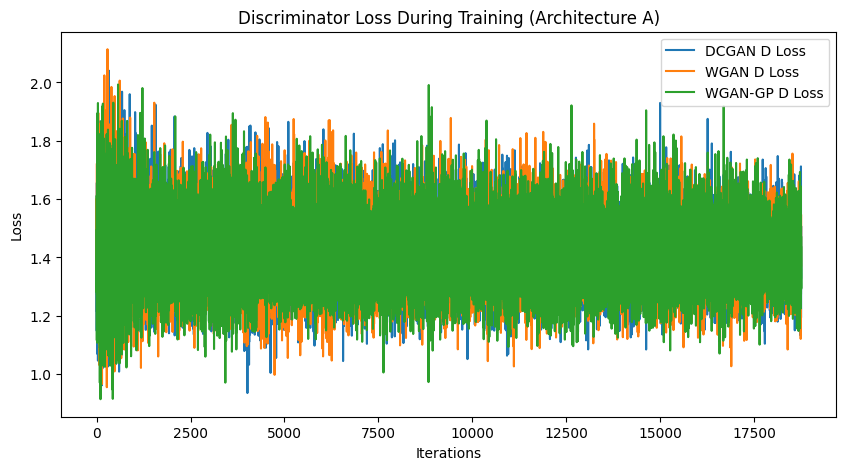

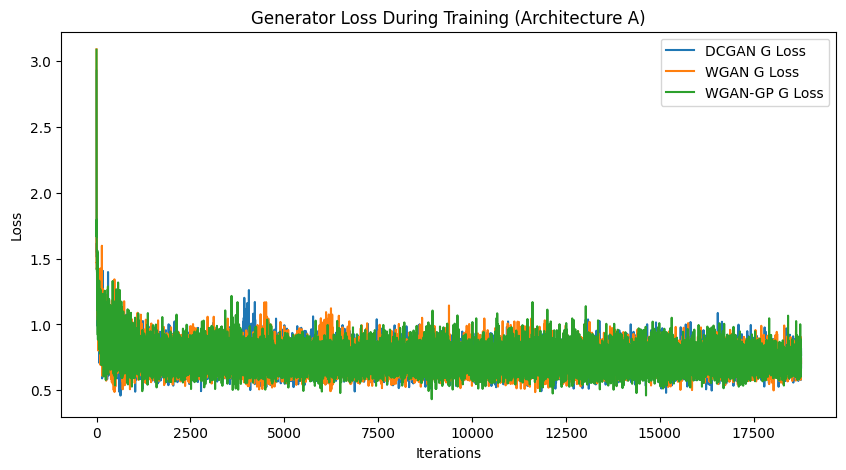

In [57]:
# Plotting Losses for Architecture A
plt.figure(figsize=(10,5))
for gan_type in gan_types:
    plt.plot(results['A'][gan_type]['D_losses'], label=f"{gan_type} D Loss")
plt.title("Discriminator Loss During Training (Architecture A)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for gan_type in gan_types:
    plt.plot(results['A'][gan_type]['G_losses'], label=f"{gan_type} G Loss")
plt.title("Generator Loss During Training (Architecture A)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

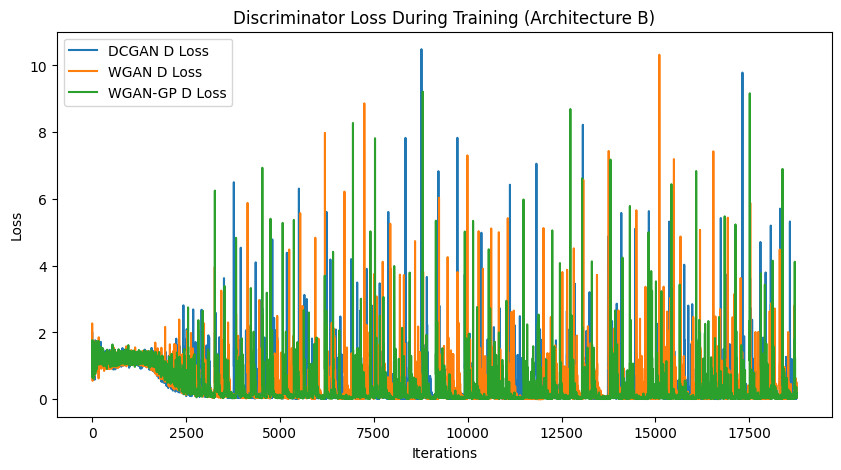

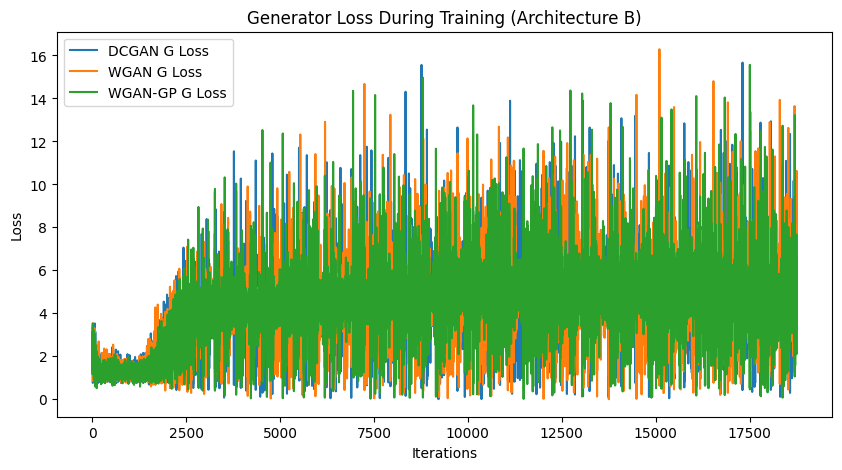

In [58]:
# Plotting Losses for Architecture B
plt.figure(figsize=(10,5))
for gan_type in gan_types:
    plt.plot(results['B'][gan_type]['D_losses'], label=f"{gan_type} D Loss")
plt.title("Discriminator Loss During Training (Architecture B)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for gan_type in gan_types:
    plt.plot(results['B'][gan_type]['G_losses'], label=f"{gan_type} G Loss")
plt.title("Generator Loss During Training (Architecture B)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [77]:
# Checking convergence
def check_epoch_convergence(losses, threshold=0.1):
    oscillations = np.abs(np.diff(losses))  # Calculating oscillations between epochs
    failed_attempts = np.sum(oscillations > threshold)  # Counting failures per epoch
    return failed_attempts

# Tracking failed attempts for all architectures and GAN types
failed_convergences = {arch: {gan_type: 0 for gan_type in gan_types} for arch in architectures}

# Looping through training results and count failed attempts
for arch in architectures:
    for gan_type in gan_types:
        G_losses = results[arch][gan_type]['G_losses']
        D_losses = results[arch][gan_type]['D_losses']

        # Counting failed attempts for generator and discriminator losses
        G_failed = check_epoch_convergence(G_losses)
        D_failed = check_epoch_convergence(D_losses)

        # Summing all failed attempts for the given architecture and GAN type
        failed_convergences[arch][gan_type] += G_failed + D_failed

# Printing failed convergence results
for arch in architectures:
    print(f"Architecture {arch}:")
    for gan_type, count in failed_convergences[arch].items():
        print(f"  {gan_type}: {count} failed attempts")

Architecture A:
  DCGAN: 15452 failed attempts
  WGAN: 15683 failed attempts
  WGAN-GP: 16383 failed attempts
Architecture B:
  DCGAN: 21267 failed attempts
  WGAN: 21540 failed attempts
  WGAN-GP: 21801 failed attempts


Generated images for label: T-shirt/top


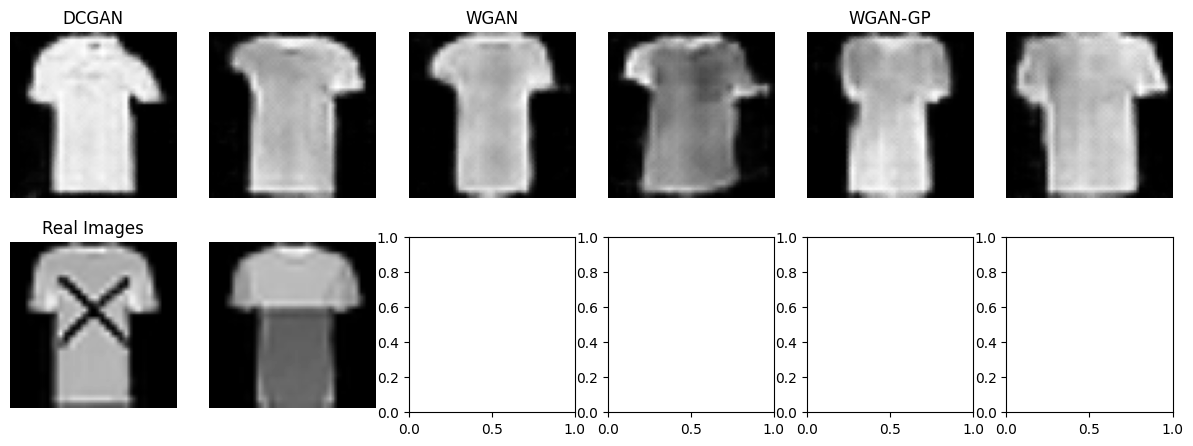

Generated images for label: Dress


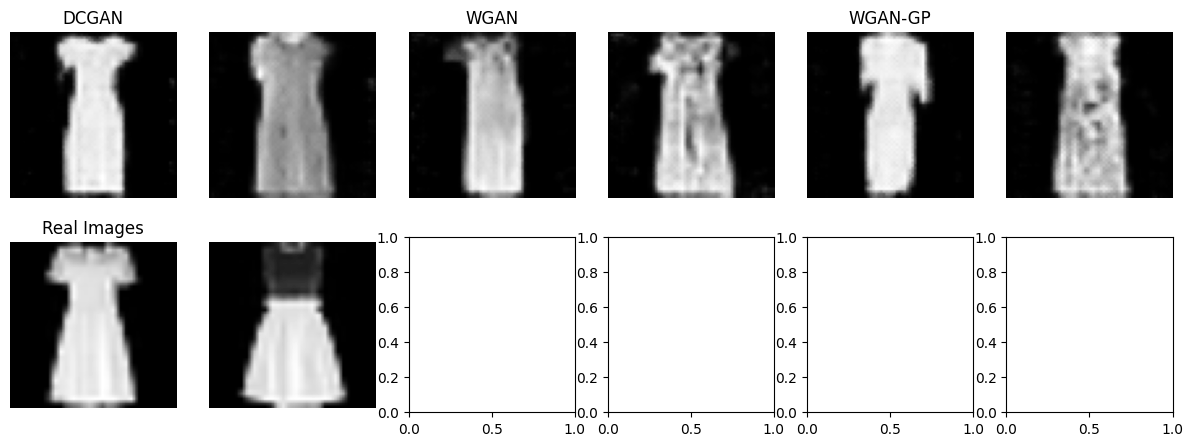

In [70]:
# Labels to generate
labels_to_generate = [0, 3]  # T-shirt/Top and Dress
num_samples = 2  # Number of samples per method per label
class_names = train_dataset.classes  # Our class names

for label in labels_to_generate:
    print(f"Generated images for label: {class_names[label]}")
    fig, axes = plt.subplots(2, 3 * num_samples, figsize=(15, 5))  # 2 samples per method
    for idx, gan_type in enumerate(['DCGAN', 'WGAN', 'WGAN-GP']):
        netG = results['B'][gan_type]['netG']  # Using architecture B (The better performing architecture)
        netG.eval()
        with torch.no_grad():
            noise = torch.randn(num_samples, nz, 1, 1, device=device)
            labels_tensor = torch.full((num_samples,), label, dtype=torch.long, device=device)
            fake_images = netG(noise, labels_tensor)
            fake_images = (fake_images * 0.5) + 0.5  # Denormalizing to [0,1]

        for i in range(num_samples):
            img = fake_images[i].cpu().numpy().transpose(1, 2, 0).squeeze()
            axes[0, idx * num_samples + i].imshow(img, cmap='gray')
            axes[0, idx * num_samples + i].axis('off')
            if i == 0:
                axes[0, idx * num_samples + i].set_title(f"{gan_type}", fontsize=12)
        if idx == 0:
            # Real images
            real_images, real_labels = next(iter(train_loader))
            real_images = (real_images * 0.5) + 0.5  # Denormalizing
            real_images = real_images[real_labels == label][:num_samples]
            for i in range(num_samples):
                img = real_images[i].cpu().numpy().transpose(1, 2, 0).squeeze()
                axes[1, i].imshow(img, cmap='gray')
                axes[1, i].axis('off')
                if i == 0:
                    axes[1, i].set_title("Real Images", fontsize=12)

    plt.show()


Generated images for label: T-shirt/top


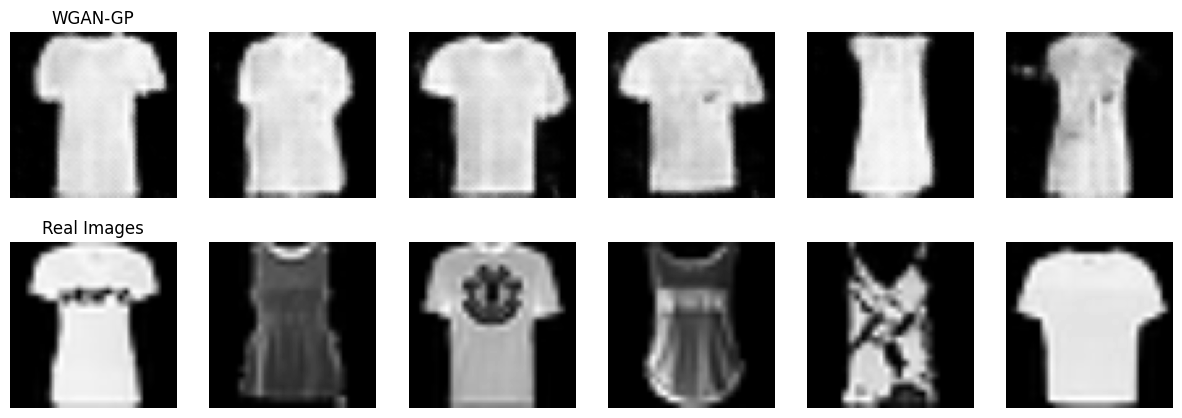

Generated images for label: Dress


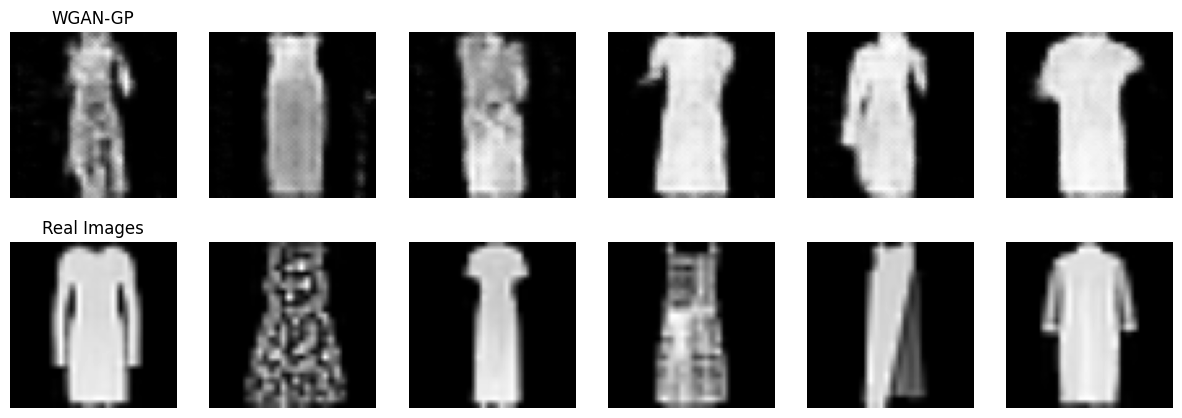

In [60]:
# Labels to generate
labels_to_generate = [0, 3]  # T-shirt/Top and Dress
num_samples = 6  # Number of samples per method
class_names = train_dataset.classes # Our class names

for label in labels_to_generate:
    print(f"Generated images for label: {class_names[label]}")
    fig, axes = plt.subplots(2, num_samples, figsize=(15,5))
    for idx, gan_type in enumerate(['DCGAN', 'WGAN', 'WGAN-GP']):
        netG = results['B'][gan_type]['netG']
        netG.eval()
        with torch.no_grad():
            noise = torch.randn(num_samples, nz, 1, 1, device=device)
            labels = torch.full((num_samples,), label, dtype=torch.long, device=device)
            fake_images = netG(noise, labels)
            fake_images = (fake_images * 0.5) + 0.5  # Denormalize to [0,1]

        for i in range(num_samples):
            img = fake_images[i].cpu().numpy().transpose(1,2,0).squeeze()
            axes[0,i].imshow(img, cmap='gray')
            axes[0,i].axis('off')
            if i == 0:
                axes[0,i].set_title(f"{gan_type}", fontsize=12)
        if idx == 0:
            # Real images
            real_images, real_labels = next(iter(train_loader))
            real_images = (real_images * 0.5) + 0.5  # Denormalize
            real_images = real_images[real_labels == label][:num_samples]
            for i in range(num_samples):
                img = real_images[i].cpu().numpy().transpose(1,2,0).squeeze()
                axes[1,i].imshow(img, cmap='gray')
                axes[1,i].axis('off')
                if i == 0:
                    axes[1,i].set_title("Real Images", fontsize=12)
    plt.show()